# **Predicting obesity level based on personal conditions**
by: Yashwitha, Samanvai, Sravs, Annette Martin


## **Objective**

Exploring demographics, lifestyle, and behavioral factors that are associated with different obesity levels to be able to identify patterns that may contribute to higher obesity risk.

Understanding risk factors can bring more awareness to help with prevention of obesity.

## Research Question

Which lifestyle and demographic factors are most strongly associated with obesity level, and how effectively can these factors be used to estimate an individual's obesity risk?

## IMPORTING & PREPPING DATA

In [1]:
# Imports
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, pearsonr, spearmanr, f_oneway, kruskal, pointbiserialr
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Downloading data
path = kagglehub.dataset_download("adeniranstephen/obesity-prediction-dataset")

# Helper function to load first data file in a folder
def load_first_data_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            return pd.read_csv(os.path.join(folder_path, file))
        elif file.endswith('.txt'):
            return pd.read_csv(os.path.join(folder_path, file), delimiter='\t')
        elif file.endswith('.xlsx'):
            return pd.read_excel(os.path.join(folder_path, file))
    raise FileNotFoundError(f"No CSV, TXT, or XLSX files found in {folder_path}")

# Load Kagglehub datasets
df = load_first_data_file(path)
df = df.drop_duplicates()

# Column Renaming
column_mapping = {
    "Gender": "Gender",
    "Age": "Age",
    "Height": "Height",
    "Weight": "Weight",
    "family_history_with_overweight": "family_history_with_overweight",
    "FAVC": "High_Calorie_Food",
    "FCVC": "Vegetable_Consumption",
    "NCP": "Main_Meals",
    "CAEC": "Snacks_Between_Meals",
    "SMOKE": "Smoking",
    "CH2O": "Water_Intake",
    "SCC": "Calorie_Monitoring",
    "FAF": "Physical_Activity",
    "TUE": "Screen_Time",
    "CALC": "Alcohol_Consumption",
    "MTRANS": "Transportation_Mode",
    "NObeyesdad": "Obesity_Level"
}
df = df.rename(columns=column_mapping)

print("Dataset 1 preview:")
display(df.head())

Using Colab cache for faster access to the 'obesity-prediction-dataset' dataset.
Dataset 1 preview:


,Gender,Age,Height,Weight,family_history_with_overweight,High_Calorie_Food,Vegetable_Consumption,Main_Meals,Snacks_Between_Meals,Smoking,Water_Intake,Calorie_Monitoring,Physical_Activity,Screen_Time,Alcohol_Consumption,Transportation_Mode,Obesity_Level
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### Descriptive statistics

In [3]:
df.describe()

,Age,Height,Weight,Vegetable_Consumption,Main_Meals,Water_Intake,Physical_Activity,Screen_Time
count,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000
mean,24.356493,1.702616,86.858706,2.421409,2.701203,2.004792,1.012827,0.663031
std,6.379977,0.093251,26.190838,0.534807,0.764655,0.608281,0.853496,0.608152
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.630000,66.000000,2.000000,2.700000,1.590000,0.125000,0.000000
50%,23.000000,1.700000,83.100000,2.400000,3.000000,2.000000,1.000000,0.631000
75%,26.000000,1.770000,108.015000,3.000000,3.000000,2.465000,1.680000,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2087 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2087 non-null   object 
 1   Age                             2087 non-null   int64  
 2   Height                          2087 non-null   float64
 3   Weight                          2087 non-null   float64
 4   family_history_with_overweight  2087 non-null   object 
 5   High_Calorie_Food               2087 non-null   object 
 6   Vegetable_Consumption           2087 non-null   float64
 7   Main_Meals                      2087 non-null   float64
 8   Snacks_Between_Meals            2087 non-null   object 
 9   Smoking                         2087 non-null   object 
 10  Water_Intake                    2087 non-null   float64
 11  Calorie_Monitoring              2087 non-null   object 
 12  Physical_Activity               2087 no

### Separate numerical & categorical columns

In [5]:
categorical_cols = df.select_dtypes(include=['object','category']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

categorical_cols, numerical_cols

(Index(['Gender', 'family_history_with_overweight', 'High_Calorie_Food',
        'Snacks_Between_Meals', 'Smoking', 'Calorie_Monitoring',
        'Alcohol_Consumption', 'Transportation_Mode', 'Obesity_Level'],
       dtype='object'),
 Index(['Age', 'Height', 'Weight', 'Vegetable_Consumption', 'Main_Meals',
        'Water_Intake', 'Physical_Activity', 'Screen_Time'],
       dtype='object'))

In [6]:
# Checking if anything is missing
df.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
High_Calorie_Food,0
Vegetable_Consumption,0
Main_Meals,0
Snacks_Between_Meals,0
Smoking,0


In [7]:
# Target Variable Handling (Ordinal Encoding)
obesity_map = {
    'Insufficient_Weight': 1,
    'Normal_Weight': 2,
    'Overweight_Level_I': 3,
    'Overweight_Level_II': 4,
    'Obesity_Type_I': 5,
    'Obesity_Type_II': 6,
    'Obesity_Type_III': 7
}

df['Obesity_Numeric'] = df['Obesity_Level'].map(obesity_map)

## EXPLORATORY DATA ANALYSIS (EDA)

### Target variable distribution

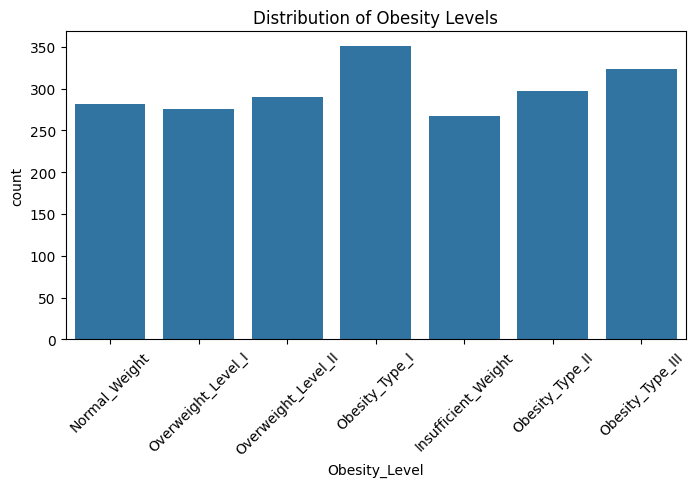

In [8]:
plt.figure(figsize=(8,4))
sns.countplot(x='Obesity_Level', data=df)
plt.xticks(rotation=45)
plt.title("Distribution of Obesity Levels")
plt.show()

### Age vs Obesity Level

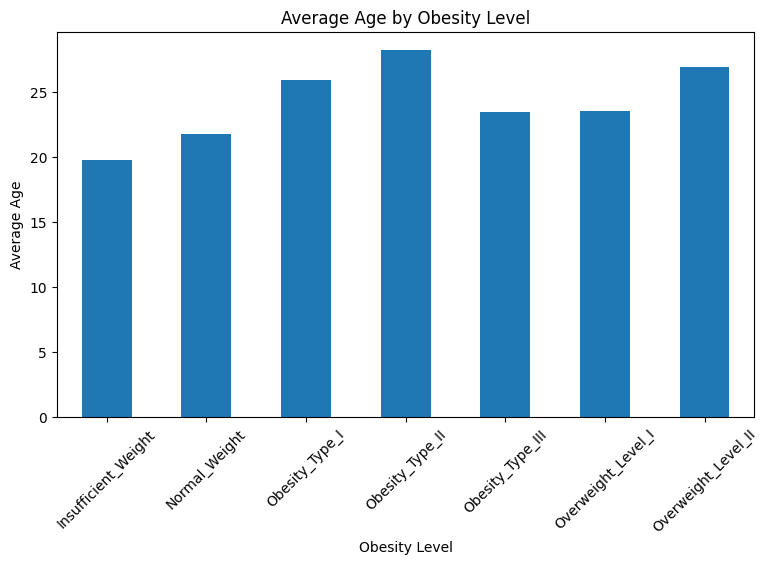

In [9]:
plt.figure(figsize=(9,5))
mean_age = df.groupby('Obesity_Level')['Age'].mean()
mean_age.plot(kind='bar')
plt.title("Average Age by Obesity Level")
plt.xlabel("Obesity Level")
plt.ylabel("Average Age")
plt.xticks(rotation=45)

plt.show()

### Weight vs Obesity Level

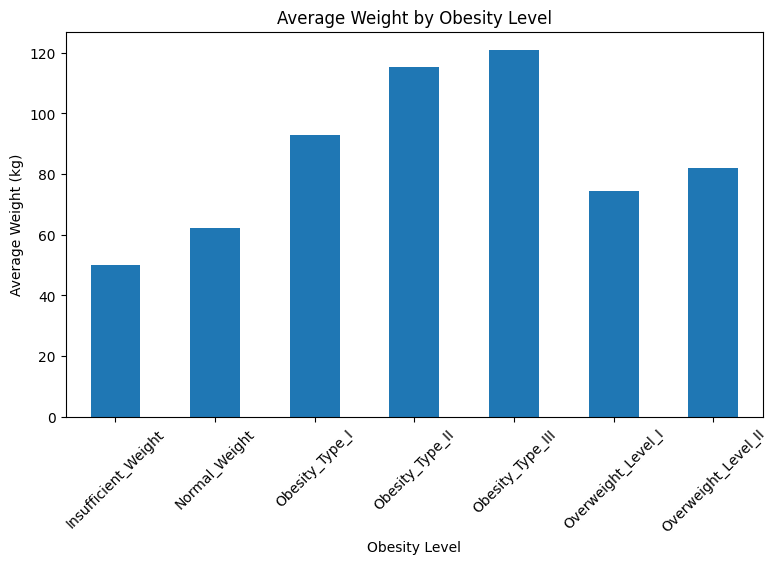

In [10]:
plt.figure(figsize=(9,5))
df.groupby('Obesity_Level')['Weight'].mean().plot(kind='bar')
plt.title("Average Weight by Obesity Level")
plt.xlabel("Obesity Level")
plt.ylabel("Average Weight (kg)")
plt.xticks(rotation=45)

plt.show()

### Height vs Obesity Level

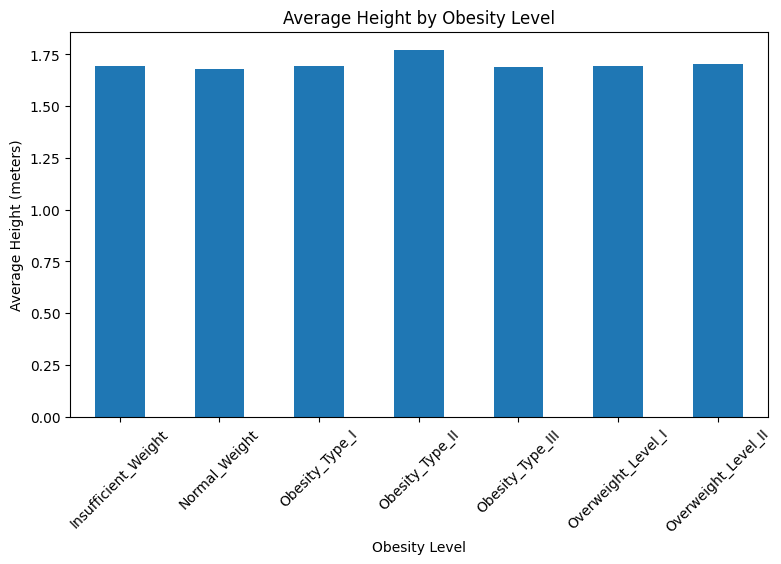

In [11]:
plt.figure(figsize=(9,5))
df.groupby('Obesity_Level')['Height'].mean().plot(kind='bar')
plt.title("Average Height by Obesity Level")
plt.xlabel("Obesity Level")
plt.ylabel("Average Height (meters)")
plt.xticks(rotation=45)

plt.show()

### Physical Activity vs Obesity Level

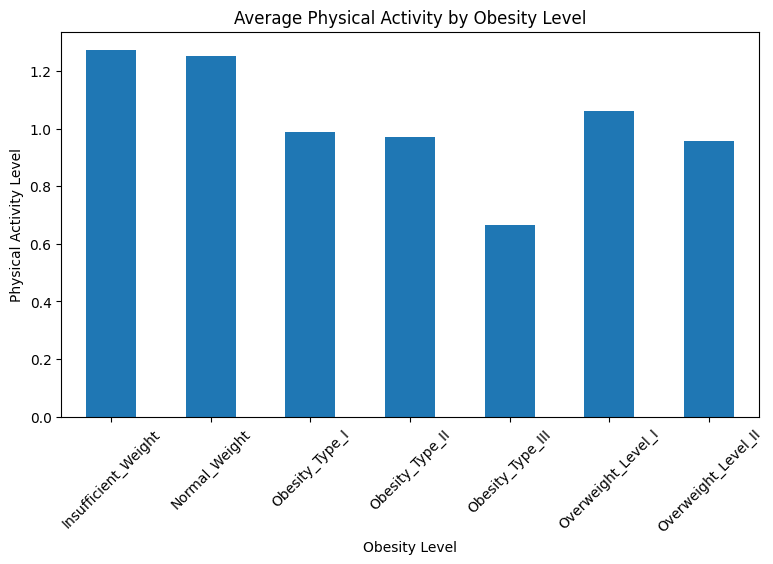

In [12]:
plt.figure(figsize=(9,5))
df.groupby('Obesity_Level')['Physical_Activity'].mean().plot(kind='bar')
plt.title("Average Physical Activity by Obesity Level")
plt.xlabel("Obesity Level")
plt.ylabel("Physical Activity Level")
plt.xticks(rotation=45)

plt.show()

### Screen Time vs Obesity Level

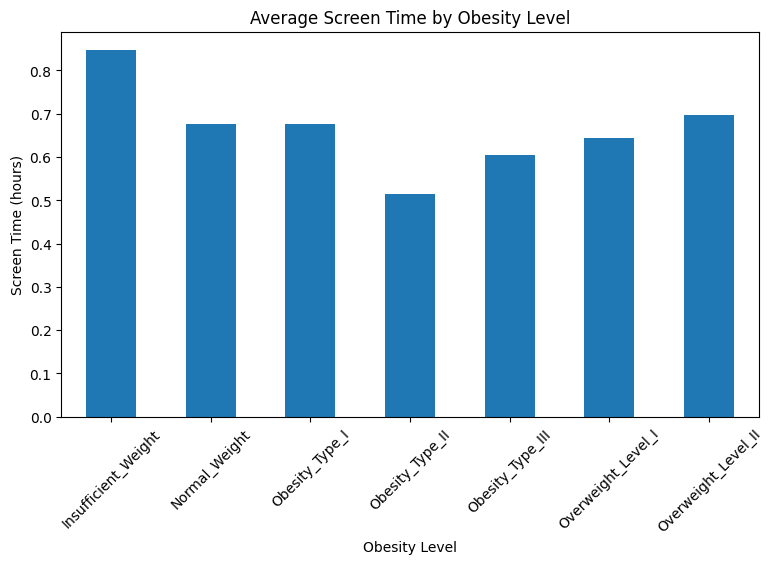

In [13]:
plt.figure(figsize=(9,5))
df.groupby('Obesity_Level')['Screen_Time'].mean().plot(kind='bar')
plt.title("Average Screen Time by Obesity Level")
plt.xlabel("Obesity Level")
plt.ylabel("Screen Time (hours)")
plt.xticks(rotation=45)

plt.show()

### High Calorie Food vs Obesity

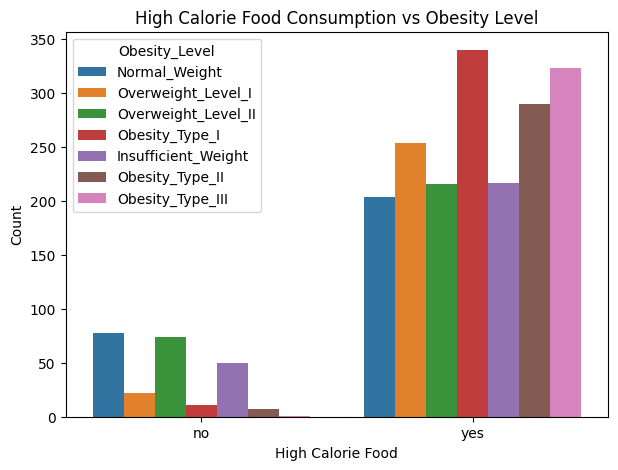

In [14]:
plt.figure(figsize=(7,5))
sns.countplot(x='High_Calorie_Food', hue='Obesity_Level', data=df)
plt.title("High Calorie Food Consumption vs Obesity Level")
plt.xlabel("High Calorie Food")
plt.ylabel("Count")

plt.show()

### Correlation Heatmap----Shows relationships between numeric features.

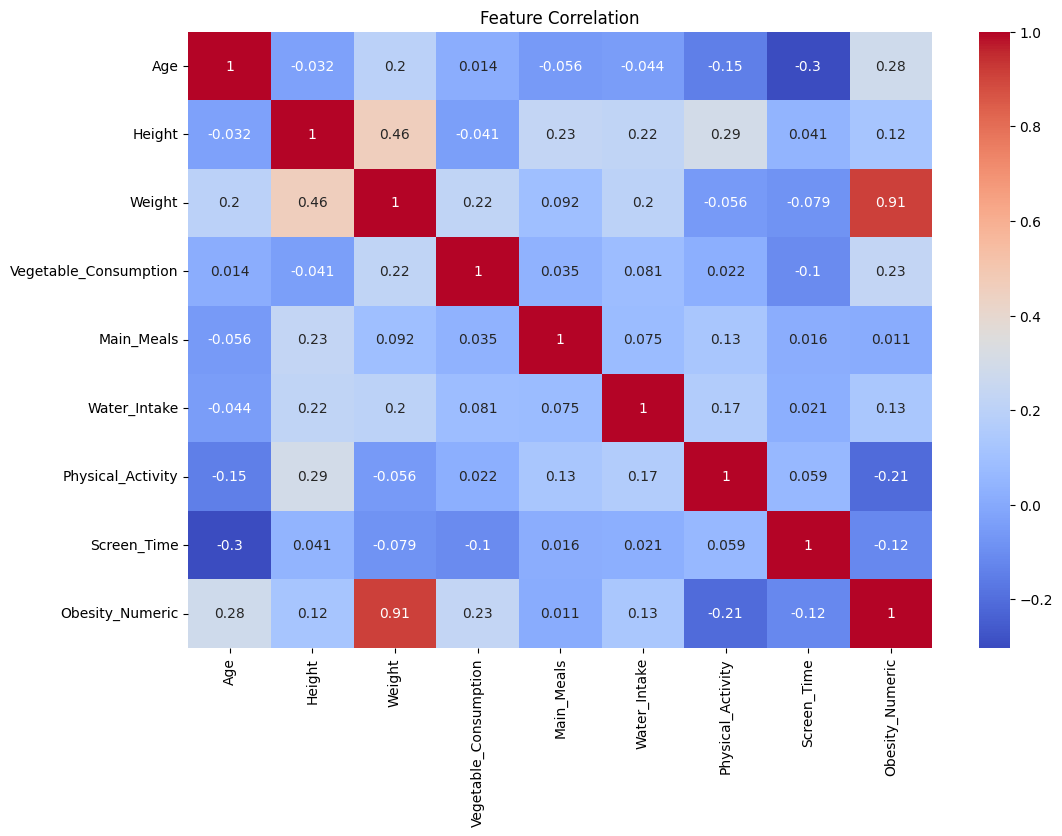

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

## STATISTICAL ANALYSIS

In [16]:
target_variable = "Obesity_Level"
numeric_target = "Obesity_Numeric"
y_numeric = df[numeric_target].copy()
y_categorical = df[target_variable].copy()

In [17]:
# Variable Exclusion
leakage_vars = ['Weight', 'Height']

df = df.drop(columns=[c for c in leakage_vars if c in df.columns])

In [18]:
# Identifying Variables

categorical_vars = [
    col for col in df.columns
    if df[col].dtype == "object"
    and col not in [target_variable]
    and col not in leakage_vars
]

continuous_vars = [
    col for col in df.select_dtypes(include=["int64", "float64"]).columns
    if col not in [numeric_target]
    if col not in leakage_vars
]

binary_vars = [
    col for col in categorical_vars
    if df[col].nunique() == 2
]

print(f"Categorical variables: {categorical_vars}")
print(f"Continuous variables: {continuous_vars}")
print(f"Binary variables: {binary_vars}")

Categorical variables: ['Gender', 'family_history_with_overweight', 'High_Calorie_Food', 'Snacks_Between_Meals', 'Smoking', 'Calorie_Monitoring', 'Alcohol_Consumption', 'Transportation_Mode']
Continuous variables: ['Age', 'Vegetable_Consumption', 'Main_Meals', 'Water_Intake', 'Physical_Activity', 'Screen_Time']
Binary variables: ['Gender', 'family_history_with_overweight', 'High_Calorie_Food', 'Smoking', 'Calorie_Monitoring']


In [19]:
# Chi-square test for categorical variables

def interpret_cramers_v(v):
    if pd.isna(v):
        return "NA"
    elif v < 0.10:
        return "Trivial"
    elif v < 0.30:
        return "Small"
    elif v < 0.50:
        return "Moderate"
    else:
        return "Strong"
# This is where I got the thresholds for Cramers V for Chi-square
# Use this in report and they also have good visuals for the equations
# https://acastat.net/statbook/chisqassoc.htm#:~:text=It%20is%20not%20affected%20by,Kendall%20's%20Tau%20b

chi_square_results = []

for col in categorical_vars:
    contingency = pd.crosstab(df[col], df[target_variable])
    chi2, p, dof, _ = chi2_contingency(contingency)

    n = contingency.values.sum()
    min_dim = min(contingency.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

    chi_square_results.append({
        "Variable": col,
        "Chi-Square": chi2,
        "p-value": p,
        "Cramers_V": cramers_v,
        "Effect_Size": interpret_cramers_v(cramers_v),
        "Statistically_Significant": p < 0.05
    })

chi_square_df = pd.DataFrame(chi_square_results)
chi_square_df.sort_values("Cramers_V", ascending=False)

,Variable,Chi-Square,p-value,Cramers_V,Effect_Size,Statistically_Significant
0,Gender,657.452978,9.357968e-139,0.561269,Strong,True
1,family_history_with_overweight,617.710993,3.524156e-130,0.544041,Strong,True
3,Snacks_Between_Meals,723.339781,6.301258e-142,0.339899,Moderate,True
2,High_Calorie_Food,231.276208,4.089708e-47,0.332893,Moderate,True
5,Calorie_Monitoring,128.030882,3.338513e-25,0.247683,Small,True
6,Alcohol_Consumption,335.564929,2.220940e-60,0.231508,Small,True
7,Transportation_Mode,288.567857,3.331989e-47,0.185923,Small,True
4,Smoking,31.854720,1.739791e-05,0.123545,Small,True


In [20]:
# ANOVA test for continuous variables

def interpret_eta_squared(eta):
    if pd.isna(eta):
        return "NA"
    elif eta < 0.01:
        return "Trivial"
    elif eta < 0.06:
        return "Small"
    elif eta < 0.14:
        return "Moderate"
    else:
        return "Large"

# Thresholds for eta-squared
# https://pmc.ncbi.nlm.nih.gov/articles/PMC12701665/#:~:text=The%20conventional%20classification%20of%20%CE%B7,)%20(7%2C%2028).

anova_results = []

for col in continuous_vars:
    data = df[[col, target_variable]].dropna()

    groups = [
        group[col].values
        for _, group in data.groupby(target_variable)
    ]

    # Parametric ANOVA
    f_stat, p_anova = f_oneway(*groups)

    # Non-parametric Kruskal-Wallis
    h_stat, p_kw = kruskal(*groups)

    # Effect size (eta squared)
    grand_mean = data[col].mean()
    ss_between = sum(len(g) * (g.mean() - grand_mean) ** 2 for g in groups)
    ss_total = sum((data[col] - grand_mean) ** 2)
    eta_sq = ss_between / ss_total if ss_total > 0 else np.nan

    anova_results.append({
        "Variable": col,
        "ANOVA_p": p_anova,
        "KW_p": p_kw,
        "Eta_squared": eta_sq,
        "Effect_Size": interpret_eta_squared(eta_sq),
        "Significant_ANOVA": p_anova < 0.05,
        "Significant_KW": p_kw < 0.05
    })

anova_df = pd.DataFrame(anova_results)
anova_df = anova_df.sort_values("ANOVA_p")
anova_df

,Variable,ANOVA_p,KW_p,Eta_squared,Effect_Size,Significant_ANOVA,Significant_KW
1,Vegetable_Consumption,4.010044e-121,3.160134e-135,0.241590,Large,True,True
0,Age,1.928296e-86,1.466296e-112,0.180604,Large,True,True
2,Main_Meals,7.037005e-31,4.500282e-49,0.071710,Moderate,True,True
4,Physical_Activity,1.181637e-20,4.697350e-18,0.049800,Small,True,True
3,Water_Intake,4.272463e-17,5.192733e-17,0.041976,Small,True,True
5,Screen_Time,1.771770e-08,5.476781e-08,0.022377,Small,True,True


In [21]:
# Bivariate correlation analysis

def interpret_correlation(r):
    r = abs(r)
    if r < 0.10:
        return "Trivial"
    elif r < 0.30:
        return "Small"
    elif r < 0.60:
        return "Moderate"
    else:
        return "Strong"

# Thresholds - this was a bit more all over the place and not a great consensus
# https://pmc.ncbi.nlm.nih.gov/articles/PMC6107969/#:~:text=The%20relationship%20(or%20the%20correlation,%2C%20and%200%20to%20%E2%88%921.

correlation_results = []

for col in continuous_vars:
  clean = pd.concat([df[col], y_numeric], axis=1).dropna()

  if len(clean) > 2:
        r_p, p_p = pearsonr(clean[col], clean[numeric_target])
        r_s, p_s = spearmanr(clean[col], clean[numeric_target])

        correlation_results.append({
            "Variable": col,
            "Pearson_r": r_p,
            "Pearson_p": p_p,
            "Spearman_rho": r_s,
            "Spearman_p": p_s,
            "Effect_Size": interpret_correlation(r_p),
            "Significant": (p_p < 0.05) or (p_s < 0.05)
        })

correlation_df = pd.DataFrame(correlation_results)
correlation_df.sort_values("Pearson_r", key=abs, ascending=False)

,Variable,Pearson_r,Pearson_p,Spearman_rho,Spearman_p,Effect_Size,Significant
0,Age,0.280412,5.178954e-39,0.404334,6.497520e-83,Small,True
1,Vegetable_Consumption,0.228736,3.541290e-26,0.264477,9.684623e-35,Small,True
4,Physical_Activity,-0.205940,2.010195e-21,-0.187075,6.851634e-18,Small,True
3,Water_Intake,0.134140,7.643307e-10,0.150574,4.708817e-12,Small,True
5,Screen_Time,-0.115332,1.269067e-07,-0.086392,7.759039e-05,Small,True
2,Main_Meals,0.010958,6.168559e-01,-0.065359,2.815222e-03,Trivial,True


In [22]:
# Point-biserial correlation for binary variables

def interpret_correlation(r):
    r = abs(r)
    if r < 0.10:
        return "Trivial"
    elif r < 0.30:
        return "Small"
    elif r < 0.50:
        return "Moderate"
    else:
        return "Strong"

#same thresholds as the Person's r cause this is a special case of pearson's correlation

point_biserial_results = []

for col in binary_vars:
    clean = df[[col, numeric_target]].dropna().copy()

    if clean[col].dtype == "object":
        clean[col] = pd.Categorical(clean[col]).codes

    r_pb, p_pb = pointbiserialr(clean[col], clean[numeric_target])

    point_biserial_results.append({
        "Variable": col,
        "PointBiserial_r": r_pb,
        "p-value": p_pb,
        "Effect_Size": interpret_correlation(r_pb),
        "Statistically_Significant": p_pb < 0.05
    })

pb_df = pd.DataFrame(point_biserial_results)
pb_df = pb_df.sort_values("PointBiserial_r", key=abs, ascending=False)
pb_df

,Variable,PointBiserial_r,p-value,Effect_Size,Statistically_Significant
1,family_history_with_overweight,0.503374,1.750567e-134,Strong,True
2,High_Calorie_Food,0.249927,4.357342e-31,Small,True
4,Calorie_Monitoring,-0.197819,7.376343e-20,Small,True
0,Gender,-0.031920,1.449184e-01,Trivial,False
3,Smoking,0.001984,9.278126e-01,Trivial,False


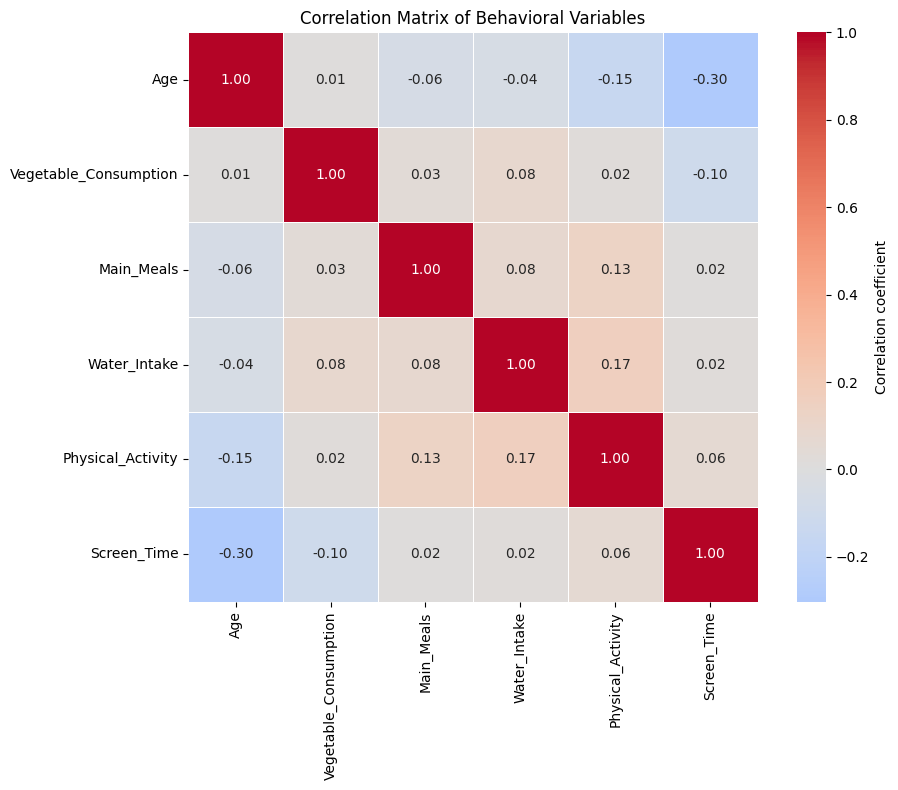

In [23]:
# Pearson correlation heatmap
plt.figure(figsize=(10, 8))

behavioral_vars = [var for var in continuous_vars if var != 'Obesity_Numeric']
corr_data = df[behavioral_vars].corr()

sns.heatmap(
    corr_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"label": "Correlation coefficient"}
)

plt.title("Correlation Matrix of Behavioral Variables")
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300)
plt.show()

## ENCODING
Changing categorical into numerical

In [24]:
le = LabelEncoder()

for col in df.select_dtypes(include="object"):
    df[col] = le.fit_transform(df[col])

# Removing the Obesity_Numeric from the df
df = df.drop('Obesity_Numeric', axis=1)

Feature & Target Split

In [25]:
X = df.drop("Obesity_Level", axis=1)
y = df["Obesity_Level"]

Train-Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Scaling

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## DATA ANALYSIS

### Logistic Regression
Logistic Regression predicts obesity categories

In [28]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.5980861244019139
              precision    recall  f1-score   support

           0       0.56      0.59      0.58        59
           1       0.44      0.28      0.34        61
           2       0.52      0.67      0.59        70
           3       0.66      0.88      0.75        64
           4       0.94      1.00      0.97        60
           5       0.47      0.36      0.41        55
           6       0.43      0.31      0.36        49

    accuracy                           0.60       418
   macro avg       0.57      0.58      0.57       418
weighted avg       0.58      0.60      0.58       418



### Random Forest

In [29]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.84688995215311
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        59
           1       0.63      0.66      0.65        61
           2       0.79      0.91      0.85        70
           3       0.97      0.94      0.95        64
           4       1.00      1.00      1.00        60
           5       0.85      0.73      0.78        55
           6       0.76      0.80      0.78        49

    accuracy                           0.85       418
   macro avg       0.85      0.84      0.84       418
weighted avg       0.85      0.85      0.85       418



### Feature Importance
This will Show which habits affect obesity the most.

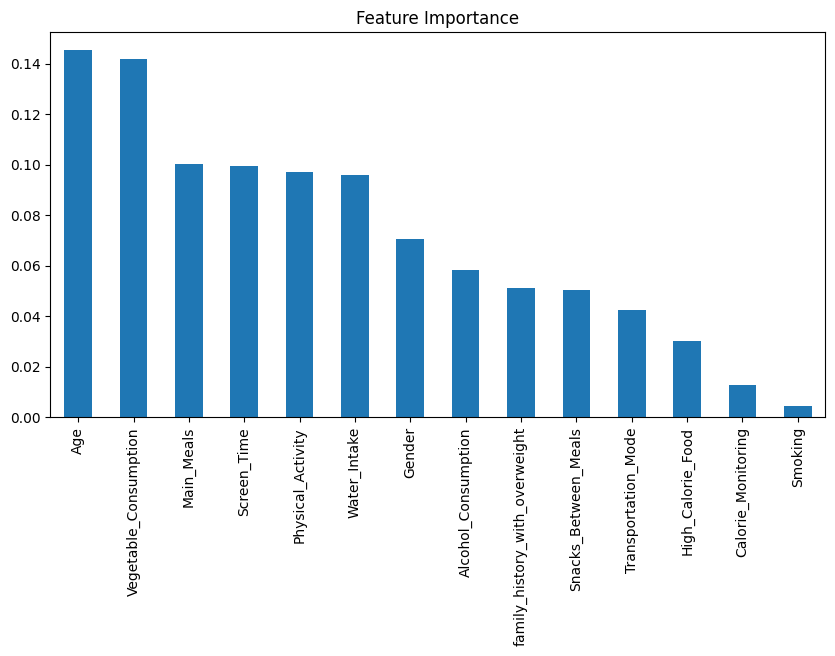

In [30]:
importance = pd.Series(rf.feature_importances_, index=X.columns)
importance.sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.title("Feature Importance")
plt.show()

## FINAL DATASET for DASHBOARD
Used Random Forest model

In [31]:
# Add predictions to original dataframe
df_dashboard = df.copy()

df_dashboard["Predicted_Obesity_Level"] = rf.predict(
    scaler.transform(df.drop("Obesity_Level", axis=1))
)

In [32]:
probabilities = rf.predict_proba(
    scaler.transform(df.drop("Obesity_Level", axis=1))
)

df_dashboard["Prediction_Confidence"] = probabilities.max(axis=1)

In [33]:
df_dashboard.to_excel("Obesity_Analysis_Final.xlsx", index=False)